In [1]:
import time

import matplotlib.pyplot as plt
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import wikipediaapi

In [2]:
wiki = wikipediaapi.Wikipedia(user_agent="waynestalk/1.0", language="en")
page = wiki.page("Oolong")
corpus = page.text

nltk.download("punkt")
sentences = nltk.sent_tokenize(corpus)
tokenized_corpus = [[word.lower() for word in nltk.word_tokenize(sentence) if word.isalpha()] for sentence in sentences]
tokenized_corpus[:5]

[nltk_data] Downloading package punkt to /Users/wayne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[['oolong',
  'uk',
  'us',
  'simplified',
  'chinese',
  '乌龙茶',
  'traditional',
  'chinese',
  '烏龍茶',
  'pinyin',
  'wūlóngchá',
  'tê',
  'black',
  'dragon',
  'tea',
  'is',
  'a',
  'traditional',
  'chinese',
  'tea',
  'camellia',
  'sinensis',
  'produced',
  'through',
  'a',
  'process',
  'that',
  'includes',
  'withering',
  'the',
  'leaves',
  'under',
  'strong',
  'sun',
  'and',
  'allowing',
  'some',
  'oxidation',
  'to',
  'occur',
  'before',
  'curling',
  'and',
  'twisting'],
 ['most',
  'oolong',
  'teas',
  'especially',
  'those',
  'of',
  'fine',
  'quality',
  'involve',
  'unique',
  'tea',
  'plant',
  'cultivars',
  'that',
  'are',
  'exclusively',
  'used',
  'for',
  'particular',
  'varieties'],
 ['the',
  'degree',
  'of',
  'oxidation',
  'which',
  'is',
  'controlled',
  'by',
  'the',
  'length',
  'of',
  'time',
  'between',
  'picking',
  'and',
  'final',
  'drying',
  'can',
  'range',
  'from',
  'to',
  'depending',
  'on',
  'the',


In [3]:
vocab = set([word for sentence in tokenized_corpus for word in sentence])
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}
len(vocab)

580

In [4]:
window_size = 2
training_pairs = []

for sentence in tokenized_corpus:
    for i in range(window_size, len(sentence) - window_size):
        context = [sentence[j] for j in range(i - window_size, i + window_size + 1) if j != i]
        training_pairs.append((context, sentence[i]))
training_pairs[:5]

[(['oolong', 'uk', 'simplified', 'chinese'], 'us'),
 (['uk', 'us', 'chinese', '乌龙茶'], 'simplified'),
 (['us', 'simplified', '乌龙茶', 'traditional'], 'chinese'),
 (['simplified', 'chinese', 'traditional', 'chinese'], '乌龙茶'),
 (['chinese', '乌龙茶', 'chinese', '烏龍茶'], 'traditional')]

In [5]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, context_words):
        vectors = self.embedding(context_words)
        average_vector = torch.mean(vectors, dim=0)
        return self.linear(average_vector)

In [6]:
model = CBOW(len(vocab), 1000)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 500

start_time = time.time()

for epoch in range(epochs):
    total_loss = 0
    for context, target in training_pairs:
        context_tensor = torch.tensor([word_to_index[word] for word in context], dtype=torch.long)
        target_tensor = torch.tensor([word_to_index[target]], dtype=torch.long)
        output = model(context_tensor)
        loss = loss_function(output.unsqueeze(0), target_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch == 0 or (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss}")

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch: 0, Loss: 6863.938150390983
Epoch: 99, Loss: 29.813918260580976
Epoch: 199, Loss: 22.255835490686877
Epoch: 299, Loss: 19.612710705710924
Epoch: 399, Loss: 18.212307975562
Epoch: 499, Loss: 17.31545850218572
Training time: 307.4530670642853 seconds


In [7]:
word = "oolong"
word_index_tensor = torch.tensor(word_to_index[word], dtype=torch.long)
embedding_vector = model.embedding(word_index_tensor).detach().numpy()
print(f"Embedding {embedding_vector.shape} for '{word}': {embedding_vector}")

Embedding (1000,) for 'oolong': [ 8.10272098e-02  2.04574251e+00 -1.22532916e+00 -9.58507061e-01
  1.10276425e+00  1.63127828e+00 -8.44756439e-02  1.34850383e+00
  4.72970784e-01 -7.29659557e-01 -5.18009305e-01  6.80394098e-02
  9.80957747e-01 -1.49213624e+00 -2.98005760e-01  3.76706421e-01
 -3.60826463e-01 -1.55519497e+00  1.05945235e-02  2.21122718e+00
 -7.74431527e-01 -1.20132184e+00 -1.72761750e+00  1.44405651e+00
 -4.55944352e-02  5.04308224e-01  7.98745573e-01 -4.96480405e-01
 -2.08563477e-01  1.72992003e+00 -1.87777802e-01 -8.56825471e-01
 -1.22243859e-01  9.54793572e-01  3.07864356e+00  1.14640224e+00
  1.30419445e+00  5.62393546e-01  1.19363987e+00  9.38829184e-01
 -2.26141191e+00 -1.17041802e+00 -1.49579227e-01 -1.94128305e-01
 -1.25341749e+00 -2.14463830e+00 -1.00191975e+00 -2.80902076e+00
 -4.14238036e-01  1.65397763e+00  2.81530470e-01  7.19205737e-01
 -8.69863153e-01 -1.25304794e+00 -6.86384514e-02  1.21084201e+00
 -9.21488106e-01 -1.93476051e-01 -5.97485423e-01  1.998858

In [8]:
sentence1 = "tea is popular in taiwan".split()
sentence2 = "oolong is famous in taiwan".split()
sentence1_embeddings = [model.embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence1]
sentence2_embeddings = [model.embedding(torch.tensor(word_to_index[word], dtype=torch.long)).detach() for word in sentence2]
vector1 = torch.stack(sentence1_embeddings).mean(dim=0)
vector2 = torch.stack(sentence2_embeddings).mean(dim=0)
cosine_sim = nn.CosineSimilarity(dim=0)
similarity = cosine_sim(vector1, vector2).item()
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Similarity between sentences: {similarity}")

Sentence 1: ['tea', 'is', 'popular', 'in', 'taiwan']
Sentence 2: ['oolong', 'is', 'famous', 'in', 'taiwan']
Similarity between sentences: 0.6197115778923035


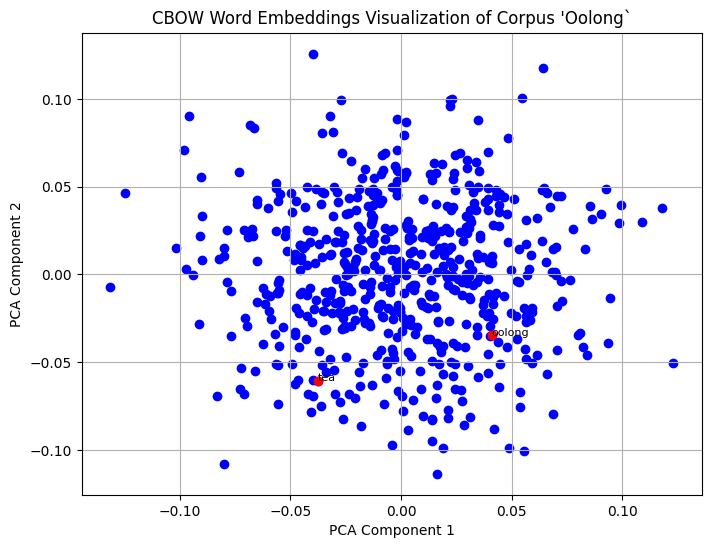

In [9]:
word_embeddings_tensor = model.embedding.weight.detach()
U, S, V = torch.pca_lowrank(word_embeddings_tensor, q=2)
reduced_embeddings = U.numpy()

plt.figure(figsize=(8, 6))

for word, index in word_to_index.items():
    x, y = reduced_embeddings[index]
    plt.scatter(x, y, marker='o', color='blue')

tea_index = word_to_index['tea']
x, y = reduced_embeddings[tea_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'tea', fontsize=8)

oolong_index = word_to_index['oolong']
x, y = reduced_embeddings[oolong_index]
plt.scatter(x, y, marker='o', color='red')
plt.text(x, y, 'oolong', fontsize=8)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("CBOW Word Embeddings Visualization of Corpus 'Oolong`")
plt.grid(True)
plt.show()